<a href="https://colab.research.google.com/github/souravs17031999/Retinal_blindness_detection_Pytorch/blob/master/Single_test_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score
import time
from tqdm import tqdm_notebook

import os
print(os.listdir("../input"))
base_dir = "../input/aptos2019-blindness-detection/"

['aptos2019-blindness-detection', 'kernel4f121f3247']


In [ ]:
print(os.listdir("../input/kernel4f121f3247"))


['__results__.html', 'custom.css', '__notebook__.ipynb', 'classifier.pt', '__results___files', '__output__.json']


In [ ]:
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '../input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)  # if getting error, use PIL to load the image here.
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
test_csv = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')


In [ ]:
test_path = "../input/aptos2019-blindness-detection/test_images/"


In [ ]:
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    #torchvision.transforms.ColorJitter(brightness=2, contrast=2),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [ ]:
test_csv['diagnosis'] = -1


In [ ]:
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
def round_off_preds(preds, coef=[0.5, 1.5, 2.5, 3.5]):
    for i, pred in enumerate(preds):
            if pred < coef[0]:
                preds[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                preds[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                preds[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                preds[i] = 3
            else:
                preds[i] = 4
    return preds

In [ ]:
def predict(testloader):
    '''Function used to make predictions on the test set'''
    model.eval()
    preds = []
    for batch_i, (data, target) in enumerate(testloader):
        data, target = data.cuda(), target.cuda()
        output = model(data)
        pr = output.detach().cpu().numpy()
        for i in pr:
            preds.append(i.item())
            
    return preds

In [ ]:
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=False) 

num_ftrs = model.fc.in_features 
out_ftrs = 5 
  
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001) 

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

In [ ]:
# to unfreeze more layers 
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [ ]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001) 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model = load_model("../input/kernel4f121f3247/classifier.pt")


In [ ]:
test_dir = "../input/aptos2019-blindness-detection/test_images/"

In [ ]:
with torch.no_grad():
    model.eval()
    p_labels = []
    img_ids = []
    i = 0
    for inputs, labels in test_loader:
        i += 1
        if i % 10 == 0:
            print(f'{i} pass step')
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        p_labels.append(preds)
    # getting ids of file images    

10 pass step
20 pass step
30 pass step


NotADirectoryError: [Errno 20] Not a directory: '../input/aptos2019-blindness-detection/test_images/42bef0737ac1.png'

In [ ]:
p_labels

[tensor([2, 2, 2, 2, 2, 2, 2, 1, 3, 0, 4, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2,
         2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 3, 2, 2, 2, 2, 1, 2, 2, 3,
         2, 2, 3, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 3, 2], device='cuda:0'),
 tensor([2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 0, 0, 0, 2, 2, 1, 2, 2, 2, 2,
         2, 1, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 0, 0, 2, 2, 2, 3, 2, 2, 0, 2, 3,
         2, 1, 2, 2, 4, 0, 2, 2, 0, 0, 3, 2, 3, 2, 2, 2], device='cuda:0'),
 tensor([0, 1, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 4, 1, 2, 4, 2, 2, 0, 1, 0, 2, 1, 2,
         2, 0, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 4, 0, 4, 3, 0, 0, 2, 4, 2, 2, 2,
         2, 3, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2], device='cuda:0'),
 tensor([0, 2, 2, 2, 4, 1, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2,
         2, 2, 2, 2, 2, 0, 0, 2, 4, 2, 2, 2, 0, 2, 2, 2, 1, 1, 3, 2, 2, 2, 2, 0,
         0, 2, 2, 0, 0, 2, 2, 4, 0, 0, 0, 1, 0, 2, 2, 0], device='cuda:0'),
 tensor([0, 1, 2, 3, 2, 2, 0, 0, 2, 2, 3, 0, 3, 

In [ ]:
pred_labels = []
for l in p_labels:
    for l1 in l:
        pred_labels.append(l1.item())

In [ ]:
sample_sub = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')


In [ ]:
sample_sub.diagnosis = pred_labels


In [ ]:
sample_sub.head

<bound method NDFrame.head of            id_code  diagnosis
0     0005cfc8afb6          2
1     003f0afdcd15          2
2     006efc72b638          2
3     00836aaacf06          2
4     009245722fa4          2
...            ...        ...
1923  ff2fd94448de          0
1924  ff4c945d9b17          2
1925  ff64897ac0d8          2
1926  ffa73465b705          3
1927  ffdc2152d455          0

[1928 rows x 2 columns]>

In [ ]:
sample_sub.to_csv('submission.csv', index=False)

In [ ]:
def test_with_single_image(model, file, transform, classes):

    file = Image.open(file).convert('RGB')

    img = transform(file).unsqueeze(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        out = model(img.to(device))
        ps = torch.exp(out)
        top_p, top_class = ps.topk(1, dim=1)
        value = top_class.item()
        print("Value:", value)
        print(classes[value])
        plt.imshow(np.array(file))
        plt.show()

In [ ]:
import random

test_dir = "../input/aptos2019-blindness-detection"
# take random folder first
folders = os.listdir(test_dir)
num = 2
path = test_dir+"/"+folders[num]
print(path)
# save label
label = folders[num]

# now take random file
files = os.listdir(path)
num = random.randint(0, len(files)-1)
name = path + "/" + files[num]
print('Path: ', name)

../input/aptos2019-blindness-detection/test_images
Real Label:  test_images
Path:  ../input/aptos2019-blindness-detection/test_images/4df7349f0806.png


Value: 2
Moderate


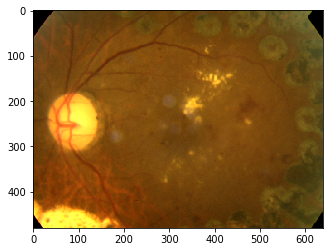

In [ ]:
classes = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
test_with_single_image(model, name, test_transforms, classes)
